## Initialization

In [103]:
import numpy as np
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import List, Literal, Tuple


@dataclass
class Parameter:
    name: str
    data: np.ndarray
    grad: np.ndarray


class Module:
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)
        
    def forward(self, *args, **kwargs):
        raise NotImplementedError

    def backward(self, *args, **kwargs):
        raise NotImplementedError
    
    def parameters(self) -> List[Parameter]:
        return []

    def zero_grad(self):
        for param in self.parameters():
            param.grad.fill(0)


# Define a custom type alias for initialization methods
InitMethod = Literal["xavier", "he", "he_leaky", "normal", "uniform"]

def parameter(
    input_size: int,
    output_size: int,
    init_method: InitMethod = "xavier",
    gain: float = 1,
    alpha: float = 0.01
) -> np.ndarray:
    weights = np.random.randn(input_size, output_size)

    if init_method == "xavier":
        std = gain * np.sqrt(1.0 / input_size)
        return std * weights
    if init_method == "he":
        std = gain * np.sqrt(2.0 / input_size)
        return std * weights
    if init_method == "he_leaky":
        std = gain * np.sqrt(2.0 / (1 + alpha**2) * (1 / input_size))
        return std * weights
    if init_method == "normal":
        return gain * weights
    if init_method == "uniform":
        return gain * np.random.uniform(-1, 1, size=(input_size, output_size))

    raise ValueError(f"Unknown initialization method: {init_method}")


class Linear(Module):
    def __init__(
        self,
        input_size: int,
        output_size: int,
        init_method: InitMethod = "xavier"
    ):
        self.input: np.ndarray = None

        self.weights: np.ndarray = parameter(input_size, output_size, init_method)
        self.d_weights: np.ndarray = np.zeros_like(self.weights)

        self.biases: np.ndarray = np.zeros((1, output_size))
        self.d_biases: np.ndarray = np.zeros_like(self.biases)

    def forward(self, x: np.ndarray) -> np.ndarray:
        self.input = x
        x1 = x @ self.weights + self.biases
        return x1
    
    def backward(self, d_out: np.ndarray) -> np.ndarray:
        self.d_weights = self.input.T @ d_out
        self.d_biases = np.sum(d_out, axis=0, keepdims=True)

        return d_out @ self.weights.T

    def parameters(self):
        return [
            Parameter(
                name="weights",
                data=self.weights,
                grad=self.d_weights
            ),
            Parameter(
                name="biases",
                data=self.biases,
                grad=self.d_biases
            ),
        ]


class BCELoss(Module):
    def forward(
        self, pred: np.ndarray, target: np.ndarray, epsilon: float = 1e-7
    ) -> np.ndarray:        
        loss = -(
            target * np.log(pred + epsilon) + 
            (1 - target) * np.log(1 - pred + epsilon)
        )

        return np.mean(loss)

    def backward(
        self, pred: np.ndarray, target: np.ndarray, epsilon: float = 1e-7
    ) -> np.ndarray:
        grad = (pred - target) / (pred * (1 - pred) + epsilon)
        return grad


class Sigmoid(Module):
    def forward(self, x: np.ndarray):
        # Apply the Sigmoid function element-wise
        self.output = 1 / (1 + np.exp(-x))
        return self.output

    def backward(self, d_out: np.ndarray):
        # Derivative of the Sigmoid function: sigmoid * (1 - sigmoid)
        ds = self.output * (1 - self.output)
        return d_out * ds


class LeakyReLU(Module):
    def __init__(self, alpha: float = 0.01):
        self.alpha = alpha

    def forward(self, x: np.ndarray):
        self.input = x
        return np.where(x > 0, x, self.alpha * x)

    def backward(self, d_out: np.ndarray):
        dx = np.ones_like(self.input)
        dx[self.input < 0] = self.alpha
        return d_out * dx


class Sequential(Module):
    def __init__(self, layers: List[Module]):
        self.layers = layers

    def forward(self, x: np.ndarray) -> np.ndarray:
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, d_out: np.ndarray, lr: float = 0.001) -> np.ndarray:
        for layer in reversed(self.layers):
            d_out = layer.backward(d_out)
        return d_out

    def parameters(self) -> List[Parameter]:
        params = []
        for i, layer in enumerate(self.layers):
            for param in layer.parameters():
                # Add unique prefix name for optimization step
                param.name = f"layer_{i}_{param.name}"
                params.append(param)
        return params


def make_spiral_dataset(
    n_samples: int = 100,
    noise: float = 0.2,
    seed: int = None,
    x_range: Tuple[int, int] = (-1, 1),
    y_range: Tuple[int, int] = (-1, 1)
):
    # Install the random seed
    if seed:
        np.random.seed(seed)

    n = n_samples // 2  # Split samples between two spirals

    # Generate first spiral
    theta1 = np.sqrt(np.random.rand(n)) * 4 * np.pi
    r1 = 2 * theta1 + np.pi
    x1 = np.stack([r1 * np.cos(theta1), r1 * np.sin(theta1)], axis=1)

    # Generate second spiral
    theta2 = np.sqrt(np.random.rand(n)) * 4 * np.pi
    r2 = -2 * theta2 - np.pi
    x2 = np.stack([r2 * np.cos(theta2), r2 * np.sin(theta2)], axis=1)

    # Combine spirals and add noise
    X = np.vstack([x1, x2])
    X += np.random.randn(n_samples, 2) * noise

    # Scale X to fit within the specified x and y ranges
    X[:, 0] = np.interp(X[:, 0], (X[:, 0].min(), X[:, 0].max()), x_range)
    X[:, 1] = np.interp(X[:, 1], (X[:, 1].min(), X[:, 1].max()), y_range)

    # Create labels
    y_range = np.zeros(n_samples)
    y_range[:n] = 0  # First spiral
    y_range[n:] = 1  # Second spiral

    return X, y_range


# Define function for plotting decision boundaries
def plot_decision_boundaries(model, X, y, bins=500):
    # Set the limits of the plot
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    # Generate a grid of points
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, bins), np.linspace(y_min, y_max, bins))
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Get the predicted class for each point in the grid
    Z = model.forward(grid)  # Only get the predicted output
    Z = (Z > 0.5).astype(int)  # Assuming binary classification

    # Reshape the predictions back to the grid shape
    Z = Z.reshape(xx.shape)

    # Plot the decision boundary
    plt.contourf(xx, yy, Z, alpha=0.8, cmap='coolwarm')
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), edgecolors='k', marker='o', s=30, label='Data Points')
    plt.title('Decision Boundary')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.colorbar()
    plt.tight_layout()
    plt.grid(True)
    plt.show()


## Generate synthetic classification data

In [104]:
n_samples = 500

x, y_target = make_spiral_dataset(n_samples=n_samples, noise=1.2, seed=1)
y_target = y_target.reshape(-1, 1)

## Training loop creator:

In [105]:
def training_loop(
    model: Module,
    loss_f: Module,
    optimizer,
    n_epoch: int = 500
):
    for epoch in range(n_epoch):
        # Forward
        y_pred = model(x)
        loss = loss_f(y_pred, y_target)

        model.zero_grad() 

        # Backward
        grad = loss_f.backward(y_pred, y_target)
        model.backward(grad)

        optimizer.step(model)

        print(f"Epoch {epoch}, Loss: {loss:.4f}")

## SGD: demo "momentum"

In [106]:
class SGD:
    def __init__(
        self,
        lr: float = 0.01,
        momentum: float = 0.0
    ):
        self.lr = lr
        self.momentum = momentum
        self.velocity = {}

    def step(self, module: Module):
        for param in module.parameters():
            param_id = param.name

            # Init velocity if not exists
            if param_id not in self.velocity:
                self.velocity[param_id] = np.zeros_like(param.data)

            grad = param.grad.copy()

            # Update momentum
            self.velocity[param_id] = self.momentum * self.velocity[param_id] - self.lr * grad

            # Update parameters
            param.data += self.velocity[param_id]

## Model, BCE, Optimizer

In [107]:
# Model architecture
model = Sequential([
    Linear(x.shape[1], 128, init_method="he_leaky"),
    LeakyReLU(alpha=0.01),
    Linear(128, 64, init_method="he_leaky"),
    LeakyReLU(alpha=0.01),
    Linear(64, 1, init_method="xavier"),
    Sigmoid()
])

bce = BCELoss()
optimizer = SGD(lr=0.01, momentum=0.9)

# Training: SGD Epic Fail!
training_loop(model, bce, optimizer)

Epoch 0, Loss: 0.7288
Epoch 1, Loss: 1.9891
Epoch 2, Loss: 7.4436
Epoch 3, Loss: 6.4521
Epoch 4, Loss: 4.3288
Epoch 5, Loss: 4.3210
Epoch 6, Loss: 0.9080
Epoch 7, Loss: 1.5553
Epoch 8, Loss: 4.7248
Epoch 9, Loss: 1.8433
Epoch 10, Loss: 8.0587
Epoch 11, Loss: 8.0590
Epoch 12, Loss: 8.0590
Epoch 13, Loss: 8.0590
Epoch 14, Loss: 8.0590
Epoch 15, Loss: 8.0590
Epoch 16, Loss: 8.0590
Epoch 17, Loss: 8.0590
Epoch 18, Loss: 8.0590
Epoch 19, Loss: 8.0590
Epoch 20, Loss: 8.0590
Epoch 21, Loss: 8.0590
Epoch 22, Loss: 8.0590
Epoch 23, Loss: 8.0590
Epoch 24, Loss: 8.0590
Epoch 25, Loss: 8.0590
Epoch 26, Loss: 8.0590
Epoch 27, Loss: 8.0590
Epoch 28, Loss: 8.0590
Epoch 29, Loss: 8.0590
Epoch 30, Loss: 8.0590
Epoch 31, Loss: 8.0590
Epoch 32, Loss: 8.0590
Epoch 33, Loss: 8.0590
Epoch 34, Loss: 8.0590
Epoch 35, Loss: 8.0590
Epoch 36, Loss: 8.0590
Epoch 37, Loss: 8.0590
Epoch 38, Loss: 8.0590
Epoch 39, Loss: 8.0590
Epoch 40, Loss: 8.0590
Epoch 41, Loss: 8.0590
Epoch 42, Loss: 8.0590
Epoch 43, Loss: 8.059

C:\Users\oaiw\AppData\Local\Temp\ipykernel_5404\1697699738.py:124: RuntimeWarning: overflow encountered in exp
  self.output = 1 / (1 + np.exp(-x))


Epoch 93, Loss: 8.0590
Epoch 94, Loss: 8.0590
Epoch 95, Loss: 8.0590
Epoch 96, Loss: 8.0590
Epoch 97, Loss: 8.0590
Epoch 98, Loss: 8.0590
Epoch 99, Loss: 8.0590
Epoch 100, Loss: 8.0590
Epoch 101, Loss: 8.0590
Epoch 102, Loss: 8.0590
Epoch 103, Loss: 8.0590
Epoch 104, Loss: 8.0590
Epoch 105, Loss: 8.0590
Epoch 106, Loss: 8.0590
Epoch 107, Loss: 8.0590
Epoch 108, Loss: 8.0590
Epoch 109, Loss: 8.0590
Epoch 110, Loss: 8.0590
Epoch 111, Loss: 8.0590
Epoch 112, Loss: 8.0590
Epoch 113, Loss: 8.0590
Epoch 114, Loss: 8.0590
Epoch 115, Loss: 8.0590
Epoch 116, Loss: 8.0590
Epoch 117, Loss: 8.0590
Epoch 118, Loss: 8.0590
Epoch 119, Loss: 8.0590
Epoch 120, Loss: 8.0590
Epoch 121, Loss: 8.0590
Epoch 122, Loss: 8.0590
Epoch 123, Loss: 8.0590
Epoch 124, Loss: 8.0590
Epoch 125, Loss: 8.0590
Epoch 126, Loss: 8.0590
Epoch 127, Loss: 8.0590
Epoch 128, Loss: 8.0590
Epoch 129, Loss: 8.0590
Epoch 130, Loss: 8.0590
Epoch 131, Loss: 8.0590
Epoch 132, Loss: 8.0590
Epoch 133, Loss: 8.0590
Epoch 134, Loss: 8.0590

## SGD: correct momentum

Velocity term:

$$v_{t+1} = \mu \cdot v_{t} + (1 - \mu) \nabla f(x_t)$$

The update rule for our position, where $\alpha$ is the step size, is:

$$x_{t+1} = x_t - \alpha \cdot v_{t+1}$$

In [108]:
class SGD:
    def __init__(
        self,
        lr: float = 0.01,
        momentum: float = 0.9,
    ):
        self.lr = lr
        self.momentum = momentum
        self.velocity = {}

    def step(self, module: Module):
        for param in module.parameters():
            param_id = param.name

            # Init velocity if not exists
            if param_id not in self.velocity:
                self.velocity[param_id] = np.zeros_like(param.data)

            grad = param.grad.copy()

            # Update momentum
            self.velocity[param_id] = (
                self.momentum * self.velocity[param_id] +
                (1 - self.momentum) * grad
            )

            # Update parameters
            param.data -= self.lr * self.velocity[param_id]

## Vanila momentum works stable!

In [109]:
# Recreate Model, BCE, optimizer
model = Sequential([
    Linear(x.shape[1], 128, init_method="he_leaky"),
    LeakyReLU(alpha=0.01),
    Linear(128, 64, init_method="he_leaky"),
    LeakyReLU(alpha=0.01),
    Linear(64, 1, init_method="xavier"),
    Sigmoid()
])

bce = BCELoss()
optimizer = SGD(lr=0.01, momentum=0.9)


training_loop(model, bce, optimizer)

Epoch 0, Loss: 0.6892
Epoch 1, Loss: 0.6489
Epoch 2, Loss: 0.6401
Epoch 3, Loss: 0.6583
Epoch 4, Loss: 0.6488
Epoch 5, Loss: 0.6320
Epoch 6, Loss: 0.6279
Epoch 7, Loss: 0.6296
Epoch 8, Loss: 0.6364
Epoch 9, Loss: 0.6319
Epoch 10, Loss: 0.6306
Epoch 11, Loss: 0.6257
Epoch 12, Loss: 0.6186
Epoch 13, Loss: 0.6180
Epoch 14, Loss: 0.6171
Epoch 15, Loss: 0.6177
Epoch 16, Loss: 0.6148
Epoch 17, Loss: 0.6095
Epoch 18, Loss: 0.6091
Epoch 19, Loss: 0.6084
Epoch 20, Loss: 0.6078
Epoch 21, Loss: 0.6043
Epoch 22, Loss: 0.6011
Epoch 23, Loss: 0.5993
Epoch 24, Loss: 0.5971
Epoch 25, Loss: 0.5954
Epoch 26, Loss: 0.5923
Epoch 27, Loss: 0.5912
Epoch 28, Loss: 0.5897
Epoch 29, Loss: 0.5880
Epoch 30, Loss: 0.5849
Epoch 31, Loss: 0.5827
Epoch 32, Loss: 0.5819
Epoch 33, Loss: 0.5791
Epoch 34, Loss: 0.5767
Epoch 35, Loss: 0.5753
Epoch 36, Loss: 0.5731
Epoch 37, Loss: 0.5712
Epoch 38, Loss: 0.5698
Epoch 39, Loss: 0.5675
Epoch 40, Loss: 0.5661
Epoch 41, Loss: 0.5644
Epoch 42, Loss: 0.5640
Epoch 43, Loss: 0.564

## Exploding gradients

In [110]:
# Recreate Model, BCE, optimizer
model = Sequential([
    Linear(x.shape[1], 128, init_method="he_leaky"),
    LeakyReLU(alpha=0.01),
    Linear(128, 64, init_method="he_leaky"),
    LeakyReLU(alpha=0.01),
    Linear(64, 1, init_method="xavier"),
    Sigmoid()
])

bce = BCELoss()
optimizer = SGD(lr=0.1, momentum=0.9)

training_loop(model, bce, optimizer)

Epoch 0, Loss: 0.6846
Epoch 1, Loss: 2.3613
Epoch 2, Loss: 4.6792
Epoch 3, Loss: 2.0382
Epoch 4, Loss: 1.3863
Epoch 5, Loss: 1.6400
Epoch 6, Loss: 6.8190
Epoch 7, Loss: 2.9502
Epoch 8, Loss: 1.3542
Epoch 9, Loss: 6.7710
Epoch 10, Loss: 6.6297
Epoch 11, Loss: 6.6631
Epoch 12, Loss: 6.6709
Epoch 13, Loss: 6.6866
Epoch 14, Loss: 6.6729
Epoch 15, Loss: 6.6779
Epoch 16, Loss: 6.6741
Epoch 17, Loss: 6.6731
Epoch 18, Loss: 6.6729
Epoch 19, Loss: 6.6729
Epoch 20, Loss: 6.6731
Epoch 21, Loss: 6.6729
Epoch 22, Loss: 6.6729
Epoch 23, Loss: 6.6729
Epoch 24, Loss: 6.6729
Epoch 25, Loss: 6.6729
Epoch 26, Loss: 6.6729
Epoch 27, Loss: 6.6729
Epoch 28, Loss: 6.6729
Epoch 29, Loss: 6.6729
Epoch 30, Loss: 6.6729
Epoch 31, Loss: 6.6729
Epoch 32, Loss: 6.6729
Epoch 33, Loss: 6.6729
Epoch 34, Loss: 6.6729
Epoch 35, Loss: 6.6729
Epoch 36, Loss: 6.6729
Epoch 37, Loss: 6.6729
Epoch 38, Loss: 6.6729
Epoch 39, Loss: 6.6729
Epoch 40, Loss: 6.6729
Epoch 41, Loss: 6.6729
Epoch 42, Loss: 6.6729
Epoch 43, Loss: 6.672

C:\Users\oaiw\AppData\Local\Temp\ipykernel_5404\1697699738.py:124: RuntimeWarning: overflow encountered in exp
  self.output = 1 / (1 + np.exp(-x))


Epoch 89, Loss: 6.6729
Epoch 90, Loss: 6.6729
Epoch 91, Loss: 6.6729
Epoch 92, Loss: 6.6729
Epoch 93, Loss: 6.6729
Epoch 94, Loss: 6.6729
Epoch 95, Loss: 6.6729
Epoch 96, Loss: 6.6729
Epoch 97, Loss: 6.6729
Epoch 98, Loss: 6.6729
Epoch 99, Loss: 6.6729
Epoch 100, Loss: 6.6729
Epoch 101, Loss: 6.6729
Epoch 102, Loss: 6.6729
Epoch 103, Loss: 6.6729
Epoch 104, Loss: 6.6729
Epoch 105, Loss: 6.6729
Epoch 106, Loss: 6.6729
Epoch 107, Loss: 6.6729
Epoch 108, Loss: 6.6729
Epoch 109, Loss: 6.6729
Epoch 110, Loss: 6.6729
Epoch 111, Loss: 6.6729
Epoch 112, Loss: 6.6729
Epoch 113, Loss: 6.6729
Epoch 114, Loss: 6.6729
Epoch 115, Loss: 6.6729
Epoch 116, Loss: 6.6729
Epoch 117, Loss: 6.6729
Epoch 118, Loss: 6.6729
Epoch 119, Loss: 6.6729
Epoch 120, Loss: 6.6729
Epoch 121, Loss: 6.6729
Epoch 122, Loss: 6.6729
Epoch 123, Loss: 6.6729
Epoch 124, Loss: 6.6729
Epoch 125, Loss: 6.6729
Epoch 126, Loss: 6.6729
Epoch 127, Loss: 6.6729
Epoch 128, Loss: 6.6729
Epoch 129, Loss: 6.6729
Epoch 130, Loss: 6.6729
Epo

## SGD with Cliping gradient

In [112]:
class SGD:
    def __init__(
        self,
        lr: float = 0.01,
        momentum: float = 0.9,
        clip_value: float = 1.0
    ):
        self.lr = lr
        self.momentum = momentum
        # Clipping value to avoid exploding gradients
        self.clip_value = clip_value
        # Store momentum for each parameter
        self.velocity = {}

    def step(self, module: Module):
        for param in module.parameters():
            param_id = param.name

            # Initialize velocity if not exists
            if param_id not in self.velocity:
                self.velocity[param_id] = np.zeros_like(param.data)

            grad = param.grad.copy()  # Make a copy to avoid modifying original

            # Gradient clipping
            if self.clip_value is not None:
                np.clip(grad, -self.clip_value, self.clip_value, out=grad)

            # Update with momentum
            self.velocity[param_id] = self.momentum * self.velocity[param_id] + (1 - self.momentum) * grad

            # Update parameters
            param.data -= self.lr * self.velocity[param_id]

## Reinit the model and the training loop

In [118]:
# Model architecture
model = Sequential([
    Linear(x.shape[1], 128, init_method="he_leaky"),
    LeakyReLU(alpha=0.01),
    Linear(128, 64, init_method="he_leaky"),
    LeakyReLU(alpha=0.01),
    Linear(64, 1, init_method="xavier"),
    Sigmoid()
])
bce = BCELoss()
# Use the lr=0.1!
optimizer = SGD(lr=0.1, momentum=0.9)

training_loop(model, bce, optimizer, n_epoch=200)

Epoch 0, Loss: 0.6755
Epoch 1, Loss: 0.6332
Epoch 2, Loss: 0.6531
Epoch 3, Loss: 0.6264
Epoch 4, Loss: 0.6637
Epoch 5, Loss: 0.6415
Epoch 6, Loss: 0.6556
Epoch 7, Loss: 0.6546
Epoch 8, Loss: 0.6448
Epoch 9, Loss: 0.6202
Epoch 10, Loss: 0.6423
Epoch 11, Loss: 0.6299
Epoch 12, Loss: 0.6352
Epoch 13, Loss: 0.6285
Epoch 14, Loss: 0.6148
Epoch 15, Loss: 0.6064
Epoch 16, Loss: 0.6092
Epoch 17, Loss: 0.6019
Epoch 18, Loss: 0.6072
Epoch 19, Loss: 0.5971
Epoch 20, Loss: 0.5937
Epoch 21, Loss: 0.5855
Epoch 22, Loss: 0.5904
Epoch 23, Loss: 0.5820
Epoch 24, Loss: 0.5796
Epoch 25, Loss: 0.5695
Epoch 26, Loss: 0.5834
Epoch 27, Loss: 0.5684
Epoch 28, Loss: 0.5820
Epoch 29, Loss: 0.5779
Epoch 30, Loss: 0.5548
Epoch 31, Loss: 0.5468
Epoch 32, Loss: 0.5640
Epoch 33, Loss: 0.5451
Epoch 34, Loss: 0.5568
Epoch 35, Loss: 0.5483
Epoch 36, Loss: 0.5363
Epoch 37, Loss: 0.5269
Epoch 38, Loss: 0.5385
Epoch 39, Loss: 0.5208
Epoch 40, Loss: 0.5256
Epoch 41, Loss: 0.5122
Epoch 42, Loss: 0.5041
Epoch 43, Loss: 0.489

## Plot decision boundaries

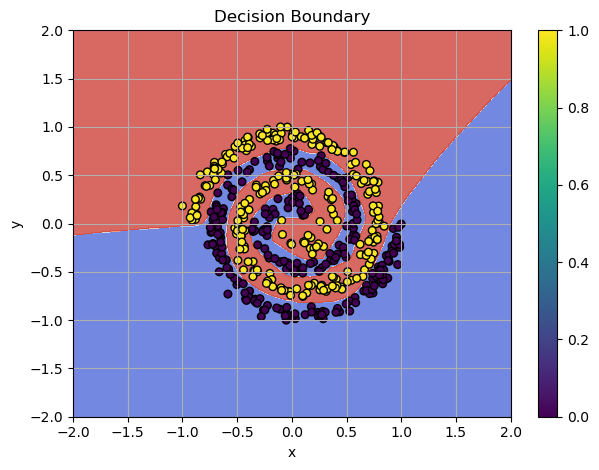

In [119]:
plot_decision_boundaries(model, x, y_target)

## Fashion-MNIST

In [120]:
from sklearn.datasets import fetch_openml

# Fetch the Fashion MNIST dataset from OpenML
fashion_mnist = fetch_openml('Fashion-MNIST', version=1, as_frame=False)

# Separate the features (images) and labels
X, y = fashion_mnist['data'], fashion_mnist['target']

# Convert labels to integers (since OpenML may return them as strings)
y = y.astype(int)

# Display dataset shape
print("Dataset shape:", X.shape, y.shape)


Dataset shape: (70000, 784) (70000,)


## Fasion MNIST

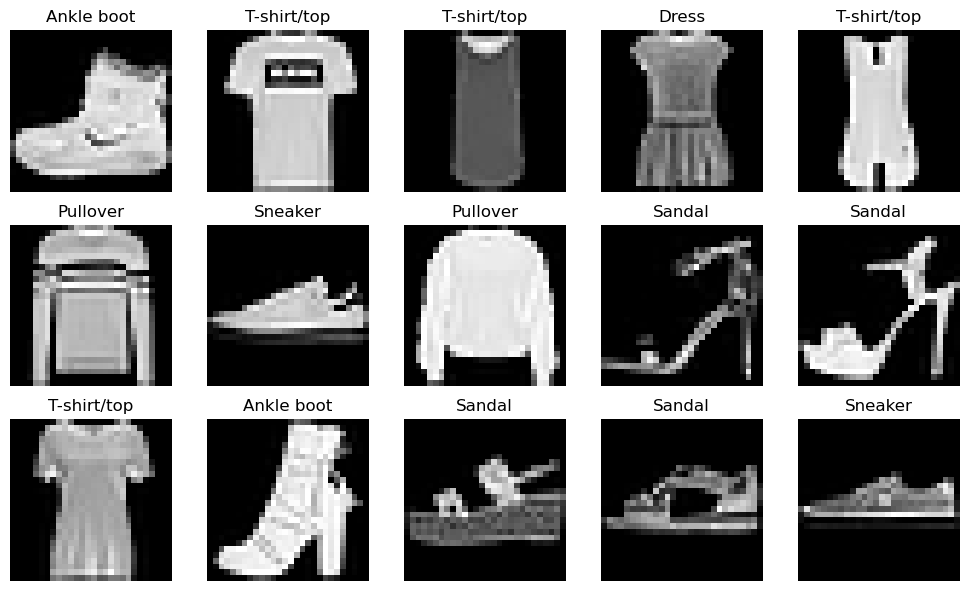

In [121]:
import matplotlib.pyplot as plt

# Define label names for Fashion MNIST classes
label_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Plot some sample images
fig, axes = plt.subplots(3, 5, figsize=(10, 6))
axes = axes.ravel()

for i in range(15):
    img = X[i].reshape(28, 28)  # Reshape the 1D array into a 28x28 image
    axes[i].imshow(img, cmap='gray')  # Display in grayscale
    axes[i].set_title(label_names[y[i]])  # Set label as title
    axes[i].axis('off')  # Hide axis

plt.tight_layout()
plt.show()

In [122]:
from sklearn.model_selection import train_test_split

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels to integers
y_train, y_test = y_train.astype(int), y_test.astype(int)

X_train.shape

(56000, 784)

In [123]:
# Convert labels to one-hot encoding
num_classes = 10
y_train_one_hot = np.eye(num_classes)[y_train]
y_test_one_hot = np.eye(num_classes)[y_test]

## Data preprocessing steps

In [124]:
from sklearn.preprocessing import MinMaxScaler

# Rescale
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


## CrossEntropyLoss and Softmax

In [125]:
class CrossEntropyLoss(Module):
    def forward(self, pred: np.ndarray, target: np.ndarray, epsilon: float = 1e-7) -> float:
        r"""
        Compute the Cross-Entropy loss for multiclass classification.

        Args:
            pred (np.ndarray): The predicted class probabilities from the model (output of softmax).
            target (np.ndarray): The one-hot encoded true target values.
            epsilon (float): A small value to avoid log(0) for numerical stability.

        Returns:
            float: The computed Cross-Entropy loss. Scalar for multiclass classification.
        """
        # Clip predictions to avoid log(0)
        pred = np.clip(pred, epsilon, 1. - epsilon)
        
        # Compute cross-entropy loss for each example
        loss = -np.sum(target * np.log(pred), axis=1)  # sum over classes for each example

        # Return the mean loss over the batch
        return np.mean(loss)
    
    def backward(self, pred: np.ndarray, target: np.ndarray, epsilon: float = 1e-7) -> np.ndarray:
        r"""
        Compute the gradient of the Cross-Entropy loss with respect to the predicted values.

        Args:
            pred (np.ndarray): The predicted class probabilities from the model (output of softmax).
            target (np.ndarray): The one-hot encoded true target values.
            epsilon (float): A small value to avoid division by zero for numerical stability.

        Returns:
            np.ndarray: The gradient of the loss with respect to the predictions.
        """

        # Clip predictions to avoid division by zero
        pred = np.clip(pred, epsilon, 1. - epsilon)

        # Compute the gradient of the loss with respect to predictions
        grad = pred - target  # gradient of cross-entropy w.r.t. predictions

        return grad


class Softmax(Module):
    """Softmax function and its derivative for backpropagation."""

    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Compute the Softmax of the input.
        Args:
            x (np.ndarray): Input array of shape (batch_size, n_classes).
        Returns:
            np.ndarray: Softmax probabilities.
        """
        # Subtract max for numerical stability
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        self.output = exp_x / np.sum(exp_x, axis=1, keepdims=True)
        return self.output

    def backward(self, d_out: np.ndarray) -> np.ndarray:
        """
        Compute the gradient of the loss with respect to the input of the softmax.
        Args:
            d_out (np.ndarray): Gradient of the loss with respect to the softmax output.
                                Shape: (batch_size, n_classes).
        Returns:
            np.ndarray: Gradient of the loss with respect to the input of the softmax.
                        Shape: (batch_size, n_classes).
        """
        # Compute batch-wise Jacobian-vector product without explicit Jacobian computation
        return self.output * (d_out - np.sum(d_out * self.output, axis=1, keepdims=True))



## Build a model with SGD

In [127]:
input_dims = 784

model = Sequential([
    Linear(input_dims, 784, init_method="he_leaky"),
    LeakyReLU(alpha=0.01),
    Linear(784, 256, init_method="he_leaky"),
    LeakyReLU(alpha=0.01),
    Linear(256, 128, init_method="he_leaky"),
    LeakyReLU(alpha=0.01),
    Linear(128, 10, init_method="xavier"),  # 10 output classes for MNIST
    Softmax()
])

bce = CrossEntropyLoss()
optimizer = SGD(lr=0.01, momentum=0.9)

In [128]:
from sklearn.metrics import accuracy_score

# Hyperparameters
epochs = 20
batch_size = 128


# Training loop
for epoch in range(epochs):
    # Shuffle training data
    indices = np.random.permutation(X_train.shape[0])
    X_train_shuffled, y_train_shuffled = X_train[indices], y_train_one_hot[indices]

    total_loss = 0
    num_batches = X_train.shape[0] // batch_size

    for i in range(0, X_train.shape[0], batch_size):
        X_batch = X_train_shuffled[i:i+batch_size]
        y_batch = y_train_shuffled[i:i+batch_size]

        # Forward pass
        preds = model(X_batch)
        loss = bce(preds, y_batch)

        # Zero grad before the backward pass!
        model.zero_grad()

        # Backward pass
        d_loss = bce.backward(preds, y_batch)
        model.backward(d_loss)

        # Update weights
        optimizer.step(model)

        total_loss += loss

    # Compute average loss
    avg_loss = total_loss / num_batches
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

# Evaluation
y_pred = model(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(y_test, y_pred_labels)

print(f"Test Accuracy: {accuracy * 100:.2f}%")

Epoch 1/20, Loss: 0.5885
Epoch 2/20, Loss: 0.4156
Epoch 3/20, Loss: 0.3807
Epoch 4/20, Loss: 0.3570
Epoch 5/20, Loss: 0.3370
Epoch 6/20, Loss: 0.3236
Epoch 7/20, Loss: 0.3089
Epoch 8/20, Loss: 0.3052
Epoch 9/20, Loss: 0.2970
Epoch 10/20, Loss: 0.2837
Epoch 11/20, Loss: 0.2757
Epoch 12/20, Loss: 0.2712
Epoch 13/20, Loss: 0.2636
Epoch 14/20, Loss: 0.2608
Epoch 15/20, Loss: 0.2513
Epoch 16/20, Loss: 0.2448
Epoch 17/20, Loss: 0.2438
Epoch 18/20, Loss: 0.2357
Epoch 19/20, Loss: 0.2325
Epoch 20/20, Loss: 0.2311
Test Accuracy: 89.94%


In [130]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1 scores per class
precision_per_class = precision_score(y_test, y_pred_labels, average=None)
recall_per_class = recall_score(y_test, y_pred_labels, average=None)
f1_per_class = f1_score(y_test, y_pred_labels, average=None)

# Create a DataFrame to store the metrics per class
metrics_df = pd.DataFrame({
    'Class': range(len(precision_per_class)),
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class
})

# Display the table
print(metrics_df)


   Class  Precision    Recall  F1-Score
0      0   0.830812  0.866571  0.848315
1      1   0.991254  0.970043  0.980534
2      2   0.870843  0.800284  0.834074
3      3   0.877632  0.920635  0.898619
4      4   0.791472  0.875461  0.831351
5      5   0.973629  0.968254  0.970934
6      6   0.759445  0.700071  0.728550
7      7   0.939844  0.977189  0.958153
8      8   0.984733  0.961252  0.972851
9      9   0.978556  0.954672  0.966467
